# Prepared data for Analysis

## Imported data and loaded in dataframe

In [801]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.preprocessing import *
from sklearn.model_selection import cross_val_score
import statsmodels.api as sm
import scipy.stats as stats
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pylab 
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

path = '../../../data/kc_housing_data.csv'
all_data = pd.read_csv('https://raw.githubusercontent.com/learn-co-students/bsc-phase-two-project/main/data/kc_house_data.csv')

In [802]:
all_data

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,...,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,263000018,5/21/2014,360000.0,3,2.50,1530,1131,3.0,0.0,0.0,...,8,1530,0.0,2009,0.0,98103,47.6993,-122.346,1530,1509
21593,6600060120,2/23/2015,400000.0,4,2.50,2310,5813,2.0,0.0,0.0,...,8,2310,0.0,2014,0.0,98146,47.5107,-122.362,1830,7200
21594,1523300141,6/23/2014,402101.0,2,0.75,1020,1350,2.0,0.0,0.0,...,7,1020,0.0,2009,0.0,98144,47.5944,-122.299,1020,2007
21595,291310100,1/16/2015,400000.0,3,2.50,1600,2388,2.0,NaN,0.0,...,8,1600,0.0,2004,0.0,98027,47.5345,-122.069,1410,1287


## Created a map of the area

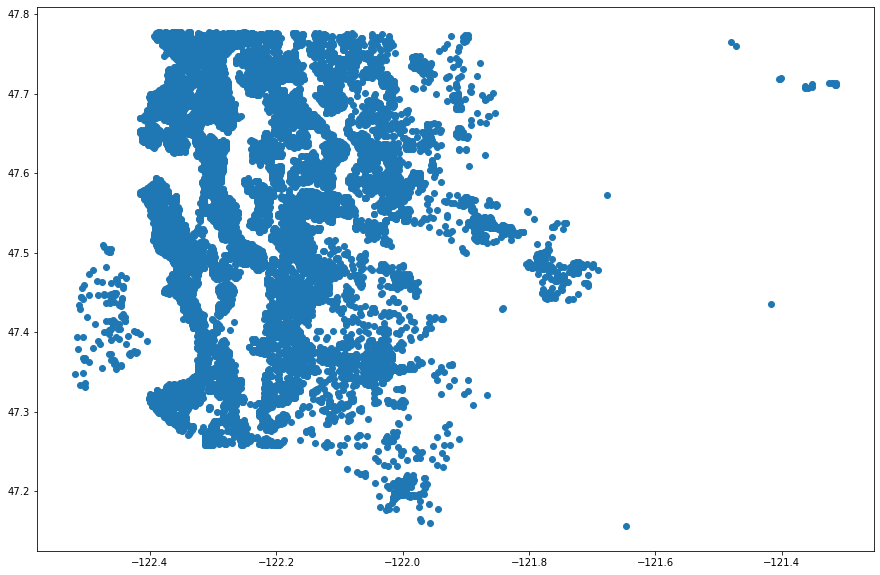

In [803]:
fig, ax = plt.subplots(figsize=(15,10))
ax.scatter(x='long', y='lat', data=all_data)

In [804]:
all_data.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')

# Creating new variables

## Added Age and Cleaned Columns

In [805]:
df = all_data.drop(['view', 'zipcode', 'lat', 'long', 'sqft_above', 'sqft_living15', 'sqft_lot15'], axis=1)

In [806]:
yrs = [int(x[-4:]) for x in df['date']]
df['date'] = yrs

In [807]:
for x in range(len(df)):
    if df['yr_renovated'][x] == True:
        if df['yr_renovated'][x] > 0:
            df['yr_built'][x] = df['yr_renovated'][x]

In [808]:
df['renovated'] = [int(x) for x in (df['yr_renovated'] > 0)]

In [809]:
df['yr_renovated/built'] = df['yr_built']

In [810]:
df['age'] = df['date'] - df['yr_renovated/built']

In [811]:
df.drop(['yr_renovated','yr_built', 'date'], axis=1, inplace=True)

## One-Hot Encoded Basement

In [812]:
df['sqft_basement'] = df['sqft_basement'].fillna(0)
df['sqft_basement'] = df['sqft_basement'].str.replace('?', '0')
df['sqft_basement'] = df['sqft_basement'].astype(float)
df['has_basement'] = [int(x) for x in df['sqft_basement'] > 0]
df = df.drop('sqft_basement', axis=1)

## Created new groups for region, and made DataFrames for country and Seattle Areas

In [895]:
df['region'] = [int(x) for x in all_data['long'] > -121.95]

In [896]:
df_country = df.loc[df['region']==1]
df_seattle = df.loc[df['region']==0]

# Test models to see what is a good variable

In [815]:
X = sm.add_constant(df[['sqft_living', 'floors', 'grade', 'age']])
y = df['price']
model_1 = sm.OLS(Y, X)
results = model_1.fit()

In [816]:
X = df[['sqft_living', 'floors', 'grade', 'age']]

In [817]:
residuals = results.resid

In [818]:
preds = results.predict()

# Making a Function to check assumptions

In [819]:
def check_model(model, X, y):
    results = model.fit()
    residuals = results.resid
    preds = results.predict()
        
    display(rainbow(results), vif(X), heteroskd(preds, y), norm_resids(residuals))
           

## Function for Varience Inflection Factor

In [1021]:
def vif(X_data):
    rows = X_data.values
    vif_df = pd.DataFrame()
    vif_df["VIF"] = [variance_inflation_factor(rows, i) for i in range(len(X_data.columns))]
    vif_df["feature"] = X_data.columns
    return vif_df

## Function of Normality of Residuals

In [822]:
def norm_resids(residuals):
    figureqq = sm.graphics.qqplot(residuals, dist=stats.norm, fit=True, line='45');

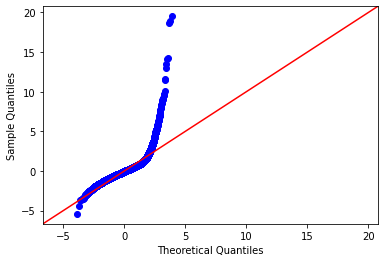

In [823]:
norm_resids(residuals)

## Function of Heteroskedascicity

In [824]:
def heteroskd (preds, Y):
    resids = preds - Y
    figure = sns.regplot(preds, resids, color='red', 
                       line_kws={'color':'blue'}, 
                       scatter_kws={'alpha':.5});
    return figure

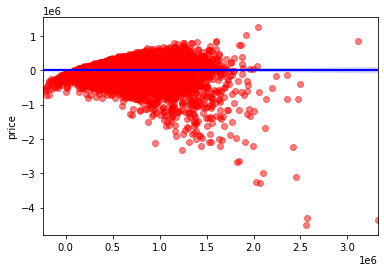

In [825]:
heteroskd(preds, Y);

## Function for Linear Rainbow Test

In [826]:
def rainbow(results):
    fstat, pvalue = sm.stats.diagnostic.linear_rainbow(results)
    return f'P-value of linearity: {pvalue}'

In [827]:
rainbow(results)

'P-value of linearity: 2.467415663044872e-09'

## Function for idenfying outliers and number of outliers

In [828]:
def outliers(df, column):
    Q1 = df[column].quantile(.25)
    Q3 = df[column].quantile(.75)
    IQR = Q3 - Q1
    lower_lim = Q1 - 1.5 * IQR
    upper_lim = Q3 + 1.5 * IQR
    
    return lower_lim, upper_lim

In [829]:
def outlier_count(column):
    high_o = (df[column] > outliers(column)[1]).sum()
    low_o = (df[column] < outliers(column)[0]).sum()
    return high_o, low_o

In [830]:
outliers(df_country, 'sqft_living')

(-295.0, 4645.0)

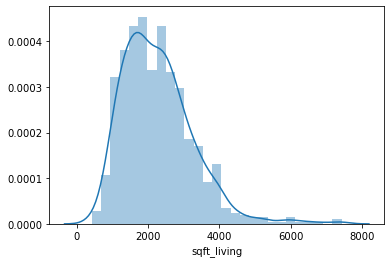

In [831]:
sns.distplot(df_country['sqft_living'])

# Models for Seattle and Country Areas

In [832]:
X_seattle = sm.add_constant(df_seattle[['sqft_living','grade','age', 'bathrooms']])
y_seattle = df_seattle['price']
X_country = sm.add_constant(df_country[['sqft_living','grade','age', 'bathrooms']])
y_country = df_country['price']
model_seattle = sm.OLS(y_seattle, X_seattle)
model_country = sm.OLS(y_country, X_country)
results_seattle = model_seattle.fit()
results_country = model_country.fit()

'P-value of linearity: 0.8629425388523382'

,VIF,feature
0,94.128933,sqft_living
1,3.972789,floors
2,3.164854,grade
3,1.927620,age


None

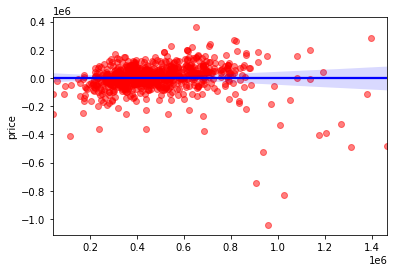

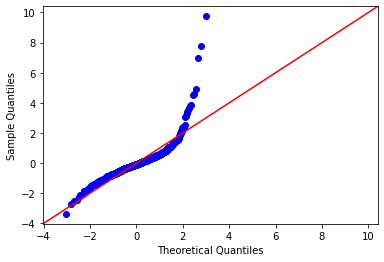

In [833]:
check_model(model_country, X_country, y_country)

# Removing Outliers from Region DataFrames

In [838]:
def df_no_outliers(data, column):
    outlier_low = (data[column] < outliers(data, column)[0])
    outlier_high = (data[column] > outliers(data, column)[1])
    return data[column][~(outlier_low | outlier_high)]

In [967]:
df_country_no_outliers.corr()['price'].map(abs).sort_values()

id                    0.013502
has_basement          0.049103
renovated             0.065581
condition             0.153973
sqft_lot              0.347170
bedrooms              0.409814
floors                0.469872
age                   0.484109
yr_renovated/built    0.485443
bathrooms             0.652839
grade                 0.769025
sqft_living           0.812745
price                 1.000000
waterfront                 NaN
region                     NaN
Name: price, dtype: float64

In [1114]:
df_seattle_no_outliers = df_seattle

In [1115]:
df_seattle_no_outliers['bathrooms'] = df_no_outliers(df_seattle, 'bathrooms')
df_seattle_no_outliers['sqft_living'] = df_no_outliers(df_seattle, 'sqft_living')
df_country_no_outliers['grade'] = df_no_outliers(df_country, 'grade')
df_seattle_no_outliers['waterfront'] = df_seattle_no_outliers.waterfront.fillna(0)
df_seattle_no_outliers = df_seattle_no_outliers.dropna()

In [1116]:
df_country_no_outliers = df_country

In [1117]:
df_country_no_outliers['bathrooms'] = df_no_outliers(df_country, 'bathrooms')
df_country_no_outliers['sqft_living'] = df_no_outliers(df_country, 'sqft_living')
df_country_no_outliers['grade'] = df_no_outliers(df_country, 'grade')
df_country_no_outliers['waterfront'] = df_country_no_outliers.waterfront.fillna(0)
df_country_no_outliers = df_country_no_outliers.dropna()

In [1118]:
df_seattle_no_outliers

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,renovated,yr_renovated/built,age,has_basement,region
0,7129300520,221900.0,3,1.00,1180.0,5650,1.0,0.0,3,7,0,1955,59,0,0
1,6414100192,538000.0,3,2.25,2570.0,7242,2.0,0.0,3,7,1,1951,63,1,0
2,5631500400,180000.0,2,1.00,770.0,10000,1.0,0.0,3,6,0,1933,82,0,0
3,2487200875,604000.0,4,3.00,1960.0,5000,1.0,0.0,5,7,0,1965,49,1,0
4,1954400510,510000.0,3,2.00,1680.0,8080,1.0,0.0,3,8,0,1987,28,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,263000018,360000.0,3,2.50,1530.0,1131,3.0,0.0,3,8,0,2009,5,0,0
21593,6600060120,400000.0,4,2.50,2310.0,5813,2.0,0.0,3,8,0,2014,1,0,0
21594,1523300141,402101.0,2,0.75,1020.0,1350,2.0,0.0,3,7,0,2009,5,0,0
21595,291310100,400000.0,3,2.50,1600.0,2388,2.0,0.0,3,8,0,2004,11,0,0


In [1119]:
df_country_no_outliers

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,renovated,yr_renovated/built,age,has_basement,region
99,7338200240,437500.0,3,2.50,2320.0,36847,2.0,0.0,3,9.0,0,1992,22,0,1
129,7853210060,430000.0,4,2.50,2070.0,4310,2.0,0.0,3,7.0,0,2004,11,0,1
147,3224079105,430000.0,2,2.50,2420.0,60984,2.0,0.0,3,7.0,0,2007,7,0,1
198,2824079053,440000.0,3,2.50,1910.0,66211,2.0,0.0,3,7.0,0,1997,18,0,1
233,943100260,213000.0,2,1.00,1000.0,10200,1.0,0.0,3,6.0,0,1961,53,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21431,7853360620,425000.0,3,2.50,1950.0,5689,2.0,0.0,3,7.0,0,2009,5,0,1
21462,7853370100,599832.0,3,2.75,3230.0,5200,2.0,0.0,3,9.0,0,2014,1,1,1
21564,7853420110,594866.0,3,3.00,2780.0,6000,2.0,0.0,3,9.0,0,2013,1,0,1
21565,7853420110,625000.0,3,3.00,2780.0,6000,2.0,0.0,3,9.0,0,2013,2,0,1


In [1120]:
df_seattle_no_outliers['sqft_open'] = df_seattle_no_outliers['sqft_lot'] - df_seattle_no_outliers['sqft_living']

In [1121]:
df_country_no_outliers['sqft_open'] = df_country_no_outliers['sqft_lot'] - df_country_no_outliers['sqft_living']

In [1122]:
df_seattle_no_outliers.corr()['price'].map(abs).sort_values()

id                    0.003158
age                   0.006141
yr_renovated/built    0.006350
sqft_open             0.043216
sqft_lot              0.057135
condition             0.063205
renovated             0.123793
has_basement          0.170158
waterfront            0.200248
floors                0.240879
bedrooms              0.264305
bathrooms             0.434625
sqft_living           0.613834
grade                 0.625656
price                 1.000000
region                     NaN
Name: price, dtype: float64

In [1123]:
df_country_no_outliers.corr()['price'].map(abs).sort_values()

id                    0.028015
renovated             0.074444
has_basement          0.081868
condition             0.160495
sqft_open             0.260690
sqft_lot              0.267637
bedrooms              0.468197
age                   0.483628
yr_renovated/built    0.484745
floors                0.492898
bathrooms             0.670663
grade                 0.735302
sqft_living           0.840379
price                 1.000000
waterfront                 NaN
region                     NaN
Name: price, dtype: float64

In [1239]:
test = pd.DataFrame(df_seattle_no_outliers.groupby('grade').mean()['price'])
test['index'] = range(10)
test.set_index('index', inplace=True)
test['grade'] = [3,4,5,6,7,8,9,10,11,12]
test

,price,grade
index,,
0,2.620000e+05,3
1,2.166978e+05,4
2,2.460917e+05,5
3,3.022770e+05,6
4,4.026612e+05,7
5,5.415461e+05,8
6,7.647284e+05,9
7,9.850874e+05,10
8,1.172618e+06,11


In [1194]:
X_seattle = sm.add_constant(df_seattle_no_outliers[['sqft_living', 'grade', 'bathrooms', 'has_basement', 'waterfront']])
y_seattle = np.log(df_seattle_no_outliers['price'])
seattle_model = sm.OLS(y_seattle, X_seattle)
seattle_results = seattle_model.fit()

In [1186]:
X_country = sm.add_constant(df_country_no_outliers[['sqft_living','grade', 'has_basement']])
y_country = df_country_no_outliers['price']
country_model = sm.OLS(y_country, X_country)
country_results = country_model.fit()

In [1243]:
seattle_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.502
Model:                            OLS   Adj. R-squared:                  0.502
Method:                 Least Squares   F-statistic:                     4027.
Date:                Tue, 29 Jun 2021   Prob (F-statistic):               0.00
Time:                        16:23:50   Log-Likelihood:                -7047.3
No. Observations:               20010   AIC:                         1.411e+04
Df Residuals:                   20004   BIC:                         1.415e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           11.0645      0.020    552.633      0.000      11.025      11.104
sqft_living      0.0002   5.48e-06     38.914      0.000       0.000       0.000
grade            0.2039      0.003     59.288      0.000       0.197       0.211
bathrooms       -0.0342      0.005     -6.653      0.000      -0.044      -0.024
has_basement     0.1303      0.005     25.146      0.000       0.120       0.140
waterfront       0.6208      0.033     18.573      0.000       0.555       0.686
==============================================================================
Omnibus:                       16.725   Durbin-Watson:                   1.969
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               16.263
Skew:                           0.054   Prob(JB):                     0.000294
Kurtosis:                       2.913   Cond. No.                     2.89e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.89e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

'P-value of linearity: 0.998536567598279'

,VIF,feature
0,67.712656,const
1,2.763497,sqft_living
2,2.197338,grade
3,2.114746,bathrooms
4,1.074495,has_basement
5,1.003772,waterfront


None

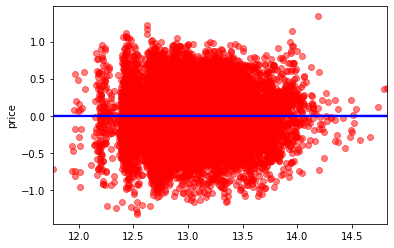

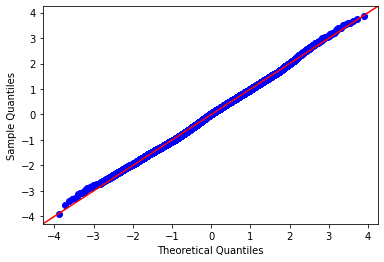

In [1196]:
check_model(seattle_model, X_seattle, y_seattle)

'P-value of linearity: 0.9554586904146475'

,VIF,feature
0,88.680519,const
1,1.994746,sqft_living
2,1.994746,grade


None

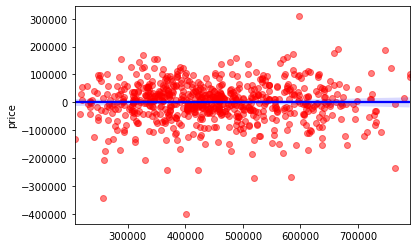

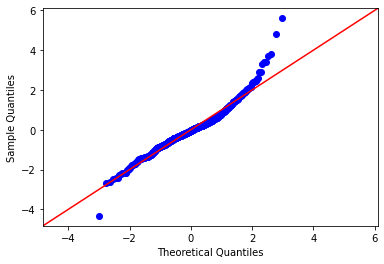

In [1162]:
check_model(country_model, X_country, y_country)

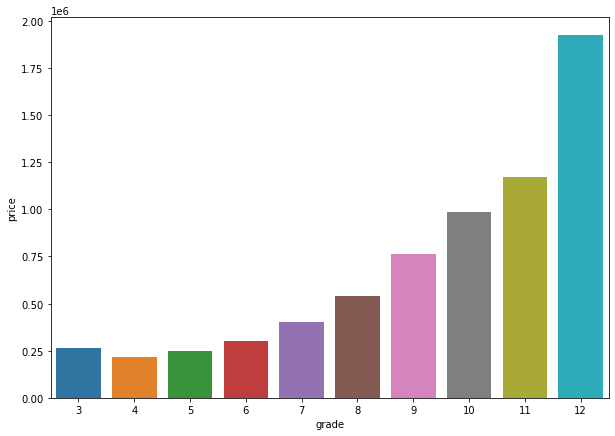

In [1242]:
fig, ax = plt.subplots(figsize=(10,7))
sns.barplot(data = test, x='grade', y='price')